## Double the meridional extent to see if it affects zonal wave generation due to reflections

Read in, fix, re-save

In [2]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")

import autolib as al
from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35221 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35221/status,
Dashboard: /proxy/35221/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40269,Workers: 7
Dashboard: /proxy/35221/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:33173,Total threads: 4
Dashboard: /proxy/39907/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33881,


In [5]:
forcing_10hrs = xr.open_dataset("/g/data/v45/ab8992/mom6_channel_configs/revision/duration_ridge_20layer/duration_ridge_20layer_duration-10/storm_windstress.nc")

forcing_10hrs.STRESS_X.values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [3]:
def save_topo(x,y,STRESS_X,STRESS_Y,layerdensities,eta,tname,savewind =True,savedensities = True):
   
    outfolder = "/g/data/v45/ab8992/mom6_channel_configs/" + tname
    
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
        
        
    else:
        if "driver-layers-topo-densities.nc" in os.listdir(outfolder):
            os.remove(outfolder + "/driver-layers-topo-densities.nc")
        if "storm_windstress.nc" in os.listdir(outfolder):
            os.remove(outfolder + "/storm_windstress.nc")
    
    if savedensities == True:
        driverfilename = outfolder+'/driver-layers-topo-densities.nc'
        ncOutput = Dataset(driverfilename, 'w', format='NETCDF4')
        ncOutput.createDimension('x', len(x))
        ncOutput.createDimension('y', len(y))
        ncOutput.createDimension('Layer', eta.shape[0] - 1)
        ncOutput.createDimension('interface', eta.shape[0])
        ncX = ncOutput.createVariable('x', 'float', ('x',))
        ncX[:] = x
        ncY = ncOutput.createVariable('y', 'float', ('y',))
        ncY[:] = y
        ncL = ncOutput.createVariable('Layer', 'float', ('Layer',))
        ncL[:] = layerdensities
        ncEta = ncOutput.createVariable('eta', 'float', ('interface', 'y', 'x'))
        ncEta[:] = eta
        ncTopo = ncOutput.createVariable('topo', 'float', ('y', 'x'))
        ncTopo[:] = -eta[-1]
        ncOutput.close()
    # wind stress
    
    if savewind == True:
        windfilename = outfolder+'/storm_windstress.nc'
        ncOutput = Dataset(windfilename, 'w',format="NETCDF4")
        ncOutput.createDimension('x', eta.shape[2])
        ncOutput.createDimension('y', eta.shape[1])
        ncOutput.createDimension('time', size = None)
        ncX = ncOutput.createVariable('x', 'float', ('x', ))
        ncX[:] = x
        ncY = ncOutput.createVariable('y', 'float', ('y', ))
        ncY[:] = y
        nctime = ncOutput.createVariable('time', 'float', ('time', ))
        nctime[:] = np.arange(0,STRESS_X.shape[0] * 2,2)
        ncSX = ncOutput.createVariable('STRESS_X', 'float', ('time','y','x'))
        ncSX[:] = STRESS_X
        ncSY = ncOutput.createVariable('STRESS_Y', 'float', ('time','y', 'x'))
        ncSY[:] = STRESS_Y
        ncOutput.close()

        
    return

def windstress_gaussian(forcing_latwidth = 600,duration = 5,strength = 1,nx=1000,ny=1000,stationary_period = 0,forcing_lonwidth = None,reverse = False):
    ## Duration is a sin**2 function that lasts exactly as long as the duration. Spatially, Gaussian with width marking 3 Std Devs from centre
    
    
    days_forcing = 1
    # stationary_period = 60 #minutes
    forcing_period = 12 * 60 #minutes. Force for 12hrs even if duration is much smaller for simplicity. 
    npoints = (2 * stationary_period + forcing_period) // 2 #since there's a point every two minutes
    print(npoints)
    points_per_hour = 30
    hours_forcing = npoints / points_per_hour
    # windstress = np.real(T_sin2(np.linspace(0,hours_forcing,npoints),h = h,offset = stationary_period / 60))   # Inputs are in hours
    # windstress[npoints - 15:] = 0
    
    tgrid = np.linspace(0,hours_forcing,npoints)
    offset = stationary_period / 60
    windstress = 0.5 * np.sin(np.pi * (tgrid - offset)/duration)**2

    windstress *= (offset < tgrid) # remove forcing during the offset (at rest) period
    windstress *= (offset + duration > tgrid) # remove forcing during after forcing has finished (don't let sinusoid start again)
    if reverse == True:
        windstress2 = -0.5 * np.sin(np.pi * (tgrid - offset - duration)/duration)**2

        windstress2 *= (duration + offset < tgrid) # remove forcing during the offset (at rest) period
        windstress2 *= (offset + 2 * duration > tgrid) # remove forcing during after forcing has finished (don't let sinusoid start again)
        windstress += windstress2
    ## Spread forcing over domain with decaying exponential towards boundaries
    STRESS_X = np.zeros([npoints,ny, nx])
    STRESS_Y = np.zeros([npoints,ny, nx])

    ## Altered loop below so that forcing starts and finishes at forcing_latwidth
    ylower = ny//2 - forcing_latwidth
    yupper = ny//2 + forcing_latwidth
    
    ## Modification Feb 20th: For OBCs we don't want forcing right up to the boundary because this gives weird edge effects. Want to taper off 
    ## the meridional forcing near the edges
    if forcing_lonwidth == None:
        for t in range(npoints):
            for j in range(ny):
                STRESS_X[t,j,:] = np.exp((-0.5 * (ny//2 - j - 0.5)**2)/((0.25 * 0.33 * forcing_latwidth)**2)) * windstress[t]
            
            
    return strength * STRESS_X,STRESS_Y


In [6]:
### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 20             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 2000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(0, Lx, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1027.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1027,1029,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km


## Value s from first pass! 
## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.25,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750,1000,1250,1500,2000] + [500,650,700]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] + [7,8,12,14,15,16,20] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10] + [5,6,7,8,9]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] + [75,125,150,300,400,500,600,700,800,1000]

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000] + [250,400]

expt_suite_name = "revision"

## New values to fill in gaps


In [7]:
STRESS_X , STRESS_Y = windstress_gaussian(nx = nx,
                                           ny = ny,
                                           duration=default_duration,
                                           strength=default_strength,
                                           forcing_latwidth = default_forcing_latwidth,
                                           reverse = True)
eta = al.eta_gaussian_hill(
        nlayers=nlayers,
        ridge=True,
        nx = nx,
        ny = ny,
        height = default_height
        )
al.save_topo(x,y,STRESS_X,STRESS_Y,eta,tname = "revision/double-yextent",savewind =True,savedensities = True)

360


In [64]:
mom6out = xr.open_dataset("/home/149/ab8992/bottom_near_inertial_waves/revision/RemoveReflections/archive/output000/u_10min.nc",decode_times=False)
forcing = xr.open_dataset("/g/data/v45/ab8992/mom6_channel_configs/revision/fix10-hrs/storm_windstress.nc",decode_times=False)

forcing.time.attrs = mom6out.time.attrs

forcing.to_netcdf("/g/data/v45/ab8992/mom6_channel_configs/revision/fix10-hrs/windstress_withdims.nc")

In [65]:
forcing

<xarray.Dataset> Size: 6GB
Dimensions:   (x: 2000, y: 500, time: 360)
Coordinates:
  * x         (x) float64 16kB 0.0 2.0 4.0 6.0 ... 3.994e+03 3.996e+03 3.998e+03
  * y         (y) float64 4kB -500.0 -498.0 -496.0 -494.0 ... 494.0 496.0 498.0
  * time      (time) float64 3kB 0.0 2.0 4.0 6.0 8.0 ... 712.0 714.0 716.0 718.0
Data variables:
    STRESS_X  (time, y, x) float64 3GB ...
    STRESS_Y  (time, y, x) float64 3GB ...

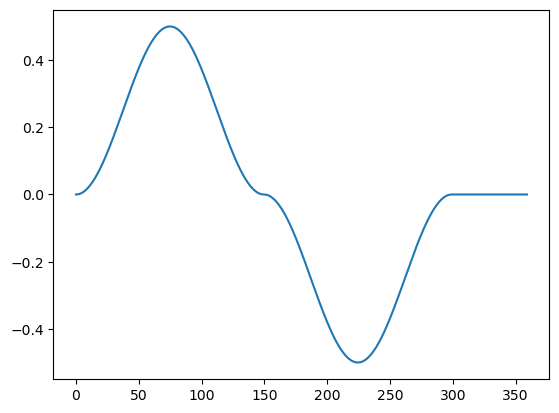

In [50]:
plt.plot(STRESS_X[:,250,1000])

In [43]:
STRESS_X.shape

(390, 500, 2000)